In [3]:
import pandas as pd
import numpy as np
from PIL import Image

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

from skimage.feature import local_binary_pattern

import matplotlib.pyplot as plt

In [4]:
def read_data(mode="train", p=0.2, seed=None):
    """
    Read the training/testing files and return the input data and labels.

    Parameters:
    ----------
    mode (str): 'train' or 'test' to read the training or testing data.
    p (float): fraction of the data to read. Useful for debugging.
    seed (int): random seed to use for reproducibility.

    Returns:
    -------
    X (np.array): input data
    y (np.array): labels
    """
    if mode == "train" or mode == "test":
        data = pd.read_csv('train.csv')
        mode = "train"
    elif mode == "predict":
        data = pd.read_csv('test.csv')
        mode = "test"
    else:
        raise ValueError("mode must be 'train' or 'test' or 'predict'")

    if seed is None:data = data.sample(frac=p)
    else: data = data.sample(frac=p, random_state=seed)

    X = data['im_name'].apply(lambda filename: np.asarray(Image.open(f"{mode}_ims/{filename}"))).values
    y = data['label'].values
    X = np.stack(X).reshape(-1, 32*32*3)

    return X, y

In [5]:
trainData, trainLabels = read_data("train", p=1, seed=69)
trainData, testData, trainLabels, testLabels = train_test_split(trainData, trainLabels, test_size=0.2, random_state=69)
print([sum(trainLabels == i) for i in range(10)])

subset = 10000
trainData, trainLabels = trainData[:subset], trainLabels[:subset]
trainData.shape, trainLabels.shape, testData.shape, testLabels.shape

[4017, 3973, 4033, 4009, 3960, 3992, 3984, 4007, 4069, 3956]


((10000, 3072), (10000,), (10000, 3072), (10000,))

In [6]:
trainData_red = trainData.reshape(-1, 32, 32, 3)[:, :, :, 0].reshape(-1, 32*32)
trainData_green = trainData.reshape(-1, 32, 32, 3)[:, :, :, 1].reshape(-1, 32*32)
trainData_blue = trainData.reshape(-1, 32, 32, 3)[:, :, :, 2].reshape(-1, 32*32)
trainData_greyScale = 0.2989 * trainData_red + 0.5870 * trainData_green + 0.1140 * trainData_blue
trainData_bg = 0.5 * trainData_blue + 0.5 * trainData_green

testData_red = testData.reshape(-1, 32, 32, 3)[:, :, :, 0].reshape(-1, 32*32)
testData_green = testData.reshape(-1, 32, 32, 3)[:, :, :, 1].reshape(-1, 32*32)
testData_blue = testData.reshape(-1, 32, 32, 3)[:, :, :, 2].reshape(-1, 32*32)
testData_greyScale = 0.2989 * testData_red + 0.5870 * testData_green + 0.1140 * testData_blue
testData_bg = 0.5 * testData_blue + 0.5 * testData_green

In [7]:
def lbp_features(data):
    _methods = ["default", "ror", "uniform", "nri_uniform", "var"]
    _lbp_kwargs = {
        "P": 9,
        "R": 2,
        "method": _methods[1]
    }
    print(data.shape)
    return np.array(
        [local_binary_pattern(img.astype(int).reshape((32, 32)), **_lbp_kwargs).flatten() for img in data
         ])

trainData_lbp = lbp_features(trainData_greyScale)
testData_lbp = lbp_features(testData_greyScale)
trainData_lbp.shape, testData_lbp.shape

(10000, 1024)
(10000, 1024)


((10000, 1024), (10000, 1024))

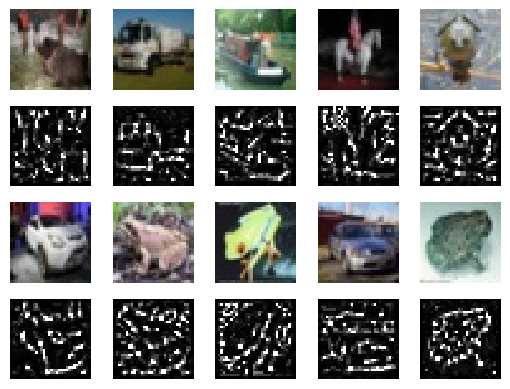

In [38]:
from matplotlib import pyplot as plt

# plt.imshow(np.reshape(trainData_lbp[0], (32, 32)), interpolation='nearest', cmap='gray')
# plt.show()

# plt.imshow(np.reshape(trainData_greyScale[0], (32, 32)), interpolation='nearest', cmap='gray')

# plt.show()

f, axarr = plt.subplots(4,5)
for i in range(10):
    axarr[(i // 5) * 2, i % 5].imshow(np.reshape(trainData[i], (32, 32, 3)), interpolation='nearest', cmap='gray')
    axarr[(i // 5) * 2 + 1, i % 5].imshow(np.reshape(trainData_lbp[i], (32, 32)), interpolation='nearest', cmap='gray')

    axarr[(i // 5) * 2, i % 5].axis('off')
    axarr[(i // 5) * 2 + 1, i % 5].axis('off')

plt.show()
# axarr[0,0].imshow(image_datas[0])
# axarr[0,1].imshow(image_datas[1])
# axarr[1,0].imshow(image_datas[2])
# axarr[1,1].imshow(image_datas[3])

In [9]:
trainData_nh = np.hstack([trainData_greyScale, trainData_lbp])
testData_nh = np.hstack([testData_greyScale, testData_lbp])
trainData_nh.shape, testData_nh.shape

((10000, 2048), (10000, 2048))

In [10]:
def blur(imgs, kernelSize=8):
    assert 32 % kernelSize == 0, "Kernel size must be a factor of 32"
    if imgs.ndim == 1: return np.mean(imgs.reshape(32, 32, 3).reshape(32//kernelSize, kernelSize, 32//kernelSize, kernelSize, 3), axis=(1, 3)).reshape(32//kernelSize * 32//kernelSize * 3)/255
    else: return np.mean(imgs.reshape(-1, 32, 32, 3).reshape(-1, 32//kernelSize, kernelSize, 32//kernelSize, kernelSize, 3), axis=(2, 4)).reshape(-1, 32//kernelSize * 32//kernelSize * 3)/255

trainData_blurred4x4 = blur(trainData)
testData_blurred4x4 = blur(testData)
trainData_blurred4x4.shape, testData_blurred4x4.shape

((10000, 48), (10000, 48))

In [11]:
trainData_hb4x4 = np.hstack([trainData_lbp, trainData_blurred4x4])
testData_hb4x4 = np.hstack([testData_lbp, testData_blurred4x4])
trainData_hb4x4.shape, testData_hb4x4.shape

((10000, 1072), (10000, 1072))

In [12]:
def normalize(data, trainData): return (data - np.min(trainData, axis=0))/(np.max(trainData, axis=0) - np.min(trainData, axis=0))
trainData_std_hb4x4 = normalize(trainData_hb4x4, trainData_hb4x4)
testData_std_hb4x4 = normalize(testData_hb4x4, trainData_hb4x4)

In [13]:
def softmax(output):
    return np.exp(output) / np.sum(np.exp(output), axis=1).reshape(-1, 1)

In [14]:
class LDA_encoder():
    def __init__(self, ndim):
        self.ndim = ndim
        self._lda = LinearDiscriminantAnalysis(n_components=ndim)
        self.classCenters = None
    def fit(self, X, y):
        _X = self._lda.fit_transform(X, y)
        self.classCenters = np.array([np.mean(_X[y == i], axis=0) for i in np.unique(y)])
    def encode(self, X):
        return 1/np.array([np.linalg.norm(self._lda.transform(X) - center, axis=1) for center in self.classCenters]).T
    def predict(self, X, prob=True):
        _X = self._lda.transform(X)
        if prob:
            return softmax(1/np.array([np.linalg.norm(_X - center, axis=1) for center in self.classCenters]).T)
        else:
            return np.argmin(np.array([np.linalg.norm(_X - center, axis=1) for center in self.classCenters]).T, axis=1)

In [15]:
lda_encoder = LDA_encoder(9)
lda_encoder.fit(trainData_hb4x4, trainLabels)
(lda_encoder.predict(testData_hb4x4, prob=False) == testLabels).mean()

0.3341

In [16]:
_lbp_methods = ["default", "ror", "uniform", "nri_uniform", "var"]

def test_lbp_features(p = 8, r = 1, method= 0):

    def lbp_feature(data):
        _lbp_kwargs = {
            "P": p,
            "R": r,
            "method": _lbp_methods[method]
        }

        return np.array(
        [local_binary_pattern(img.astype(int).reshape((32, 32)), **_lbp_kwargs).flatten() for img in data
         ])


    trainData_lbp = lbp_feature(trainData_greyScale)
    testData_lbp = lbp_feature(testData_greyScale)

    # trainData_nh = np.hstack([trainData, trainData_lbp])
    # testData_nh = np.hstack([testData, testData_lbp])

    trainData_blurred4x4 = blur(trainData)
    testData_blurred4x4 = blur(testData)

    trainData_hb4x4 = np.hstack([trainData_lbp, trainData_blurred4x4])
    testData_hb4x4 = np.hstack([testData_lbp, testData_blurred4x4])
    trainData_hb4x4.shape, testData_hb4x4.shape

    # trainData_std_hb4x4 = normalize(trainData_hb4x4, trainData_hb4x4)
    # testData_std_hb4x4 = normalize(testData_hb4x4, trainData_hb4x4)

    lda_encoder = LDA_encoder(9)
    lda_encoder.fit(trainData_hb4x4, trainLabels)
    print("P", p, "R", r, "Method", _lbp_methods[method], "Acc", (lda_encoder.predict(testData_hb4x4, prob=False) == testLabels).mean())

    

# for p in range(4, 13):
#     for r in range(1, 4):
#         for method in range(4):
#             try: 
#                 test_lbp_features(p, r, method)
#             except Exception as e:
#                 print(repr(e))
#                 print("P", p, "R", r, "Method", _lbp_methods[method], "Acc", "-Error-")

In [17]:
trainData_greyScale[0].shape

(1024,)

In [18]:
pca = PCA(n_components=20, random_state=69)
pca.fit(trainData_hb4x4)

PCA(n_components=20, random_state=69)

In [19]:
trainData_hb4x4_withEncodedDistance = np.hstack([pca.transform(trainData_hb4x4), lda_encoder.encode(trainData_hb4x4)])
testData_hb4x4_withEncodedDistance = np.hstack([pca.transform(testData_hb4x4), lda_encoder.encode(testData_hb4x4)])
trainData_hb4x4_withEncodedDistance.shape, testData_hb4x4_withEncodedDistance.shape

((10000, 30), (10000, 30))

In [20]:
lda_std_encoder = LDA_encoder(9)
lda_std_encoder.fit(trainData_std_hb4x4, trainLabels)

In [21]:
(lda_std_encoder.predict(testData_std_hb4x4, prob=False) == testLabels).mean()

0.3341

In [22]:
pca_std = PCA(n_components=66)
pca_std.fit(trainData_std_hb4x4)

PCA(n_components=66)

In [23]:
trainData_hb4x4_withEncodedDistance_std = np.hstack([pca_std.transform(trainData_std_hb4x4), lda_std_encoder.encode(trainData_std_hb4x4)])
testData_hb4x4_withEncodedDistance_std = np.hstack([pca_std.transform(testData_std_hb4x4), lda_std_encoder.encode(testData_std_hb4x4)])
trainData_hb4x4_withEncodedDistance_std.shape, testData_hb4x4_withEncodedDistance_std.shape

((10000, 76), (10000, 76))

In [24]:
svc = SVC(C=1, kernel='rbf', gamma='scale', probability=True)
svc.fit(trainData_hb4x4_withEncodedDistance, trainLabels)

SVC(C=1, probability=True)

In [25]:
(svc.predict(testData_hb4x4_withEncodedDistance) == testLabels).mean()

0.2674

In [26]:
svc_pca = SVC(C=1, kernel='rbf', gamma='scale', probability=True)
svc_pca.fit(pca.transform(trainData_hb4x4), trainLabels)

SVC(C=1, probability=True)

In [27]:
(svc_pca.predict(pca.transform(testData_hb4x4)) == testLabels).mean()

0.2674

In [28]:
svc_std = SVC(C=1, kernel='rbf', gamma='scale', probability=True)
svc_std.fit(trainData_hb4x4_withEncodedDistance_std, trainLabels)

SVC(C=1, probability=True)

In [29]:
(svc_std.predict(testData_hb4x4_withEncodedDistance_std) == testLabels).mean()

0.3541